In [1]:
from google.colab import drive
drive.mount('/content/drive')

#글꼴 설치
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fi
# !rm ~/. cache/matplotlib -rf

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#라이브러리 임포트
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import warnings
warnings.filterwarnings(action='ignore')
pd.set_option('display.max_columns', None)

#파일 불러오기
rlps = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종프/use_table/SDB2_I_CT_RLPS.csv')
cont = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종프/use_table/SDB2_I_CT_CONT_PVT.csv')
mgg = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/최종프/use_table/SDB2_I_CT_MGG_PVT.csv')


# 3보험계약정보 SDB2_I_CT_COUNT_PVT => cont
### 처리내용
- 드랍 리스트: 업권코드, 인수심사결과코드, 진단계약여부, 계약체결/해지/시기/종기/실효/부활월, 연월컬름들(20개+_정도)   
=> cont_pre1

- 단체보험여부: 1(단체, 17578건) 값을 drop한 후, 컬럼 자체 삭제
    - 회사/기관에서 소속된 사람들을 보험에 가입시켜놓는  
=>cont_pre2
  
- 증권번호: 증권번호 같은데 차주가 여러명인 경우 (70,998건) drop  
=>///70,998건이아님 6556으로 나옴   
=>cont_pre3
- 증권번호가 같은데 차주가 여러명인 증권번호 모음   
=>rlps_2upper

- 보험종류코드: 차원 축소
    - 사망류: 종신(01), 정기(02)
    - 질병류: 질병(03), 암(05)
    - 상해보험(04) 단독
    - 어린이보험(07), 실비보험(16)
    - 운전자(13) 단독
    - 여행자(14) 단독
    - 연금저축(09), 연금(10), 저축(11)
    - 기타: 간병(06), 치아(08), 교육(12), 골프(15), 기타보험(99)
    - 값 없음(0건): 자동차(17), 배상책임(19). 무시.
    - 주계약상태코드: 차원 축소
    - 01 정상(심사중) -> 날림
    - 02 정상
    - 03청약철회, 06소멸, 07해지, 08무효, (09, 10)취소 -> 보험료 환불 + 보험이 해지됨
    - 04 실효
    - 05 만기


- 납입보험료: 같은 증권번호(POL_SN)에 열이 여러개인 경우(e.g., 보험료가 변경된 경우) 평균값
- 납입주기코드, 납입기간: 중요. 그대로 둠.
- 가입경로코드: 나~~중에 인사이트 발굴용 (액션플랜쯤)

## 0번 전처리
## 하나의 증권번호에 일정 유효시점에 두개이상이 유효할 때

In [3]:
pre_0 = cont.groupby('POL_SN')[['YM_201806', 'YM_201807', 'YM_201808',
       'YM_201809', 'YM_201810', 'YM_201811', 'YM_201812', 'YM_201901',
       'YM_201902', 'YM_201903', 'YM_201904', 'YM_201905', 'YM_201906',
       'YM_201907', 'YM_201908', 'YM_201909', 'YM_201910', 'YM_201911',
       'YM_201912', 'YM_202001', 'YM_202002', 'YM_202003', 'YM_202004',
       'YM_202005', 'YM_202006']].sum().reset_index()

1928	이사람  하나의 증권번호에 유요한 계약의 개수가 많다. => 저번 문의에서 답변받은 결과를 통해 이상치로 간주
뒤에서 발견했지만 공식적으로 인정된 이상치이므로 가장 앞계에서 제거
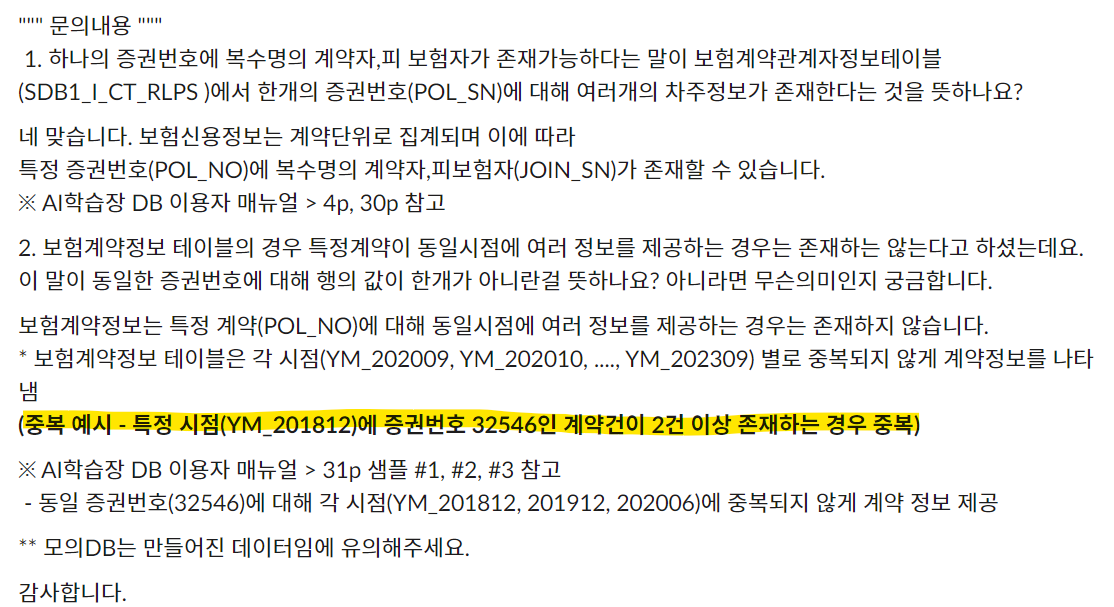


In [4]:
#이상치만 모으기
pre = pre_0[pre_0['YM_202006']>1]#13882개의 증권번호
display(pre)

#이상치 제거
cont = cont[~cont['POL_SN'].isin(pre['POL_SN'])]
display(cont)

,POL_SN,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
22,573,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
33,1146,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
52,1928,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13,13
68,2578,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
84,3203,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244170,9995198,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
244185,9995730,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3
244188,9995942,0,0,0,0,0,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
244197,9996385,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2


,SCTR_CD,POL_SN,IS_GRP_INS,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
0,6,3023157,0,3,7,200806,200903,200806,200906,999912,999912,10,2,1,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,8,2067576,0,1,2,201012,999912,201012,999912,999912,999912,33,2,20,0,1,3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,6,7995898,0,7,2,201409,999912,201409,999912,999912,999912,52,2,30,0,1,1,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0
3,8,9743978,0,4,7,201604,201704,201604,201704,999912,999912,170,3,1,0,1,4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,6,9040681,0,4,2,201804,999912,201804,204804,999912,202006,43,2,25,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368476,8,2330274,1,4,5,201905,999912,201905,202005,999912,999912,59,3,1,0,1,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
368478,8,6242384,0,7,2,201212,999912,201212,203812,999912,999912,47,2,10,0,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368480,6,6050915,0,7,7,200902,201107,200902,201902,999912,999912,15,2,10,0,1,6,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
368481,6,9901184,0,14,2,201809,999912,201809,201902,999912,999912,96,1,0,0,1,5,0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [5]:
#제거됐나 확인
cont[cont['POL_SN']==1928]

,SCTR_CD,POL_SN,IS_GRP_INS,INS_GBN_CD,INS_CT_STAT_CD,CT_CNCLS_DT,CT_TRMNT_DT,CT_ST_DT,CT_END_DT,CT_EFCTV_DT,CT_RST_DT,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,IS_CT_DIGNS,CT_JDGMT_CD,CT_CHNL_CD,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006


## 1번 전처리
##사용컬럼만 남긴df => cont_pre1

In [6]:
cont.columns
cont_use_list=['POL_SN','IS_GRP_INS', 'INS_GBN_CD', 'INS_CT_STAT_CD','CT_PY_AMT','CT_PY_CYCLE_CD', 'CT_PY_PD', 'CT_CHNL_CD','YM_202006' ]
# 사용하는 보험 컬럼 (증권번호 , 단체보험여부, 보험중류코드, 주계약상태코드 , 납입보험료, 납입기간, 가입경로)

cont_pre1 = cont[cont_use_list]
cont_pre1

,POL_SN,IS_GRP_INS,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006
0,3023157,0,3,7,10,2,1,6,1
1,2067576,0,1,2,33,2,20,3,1
2,7995898,0,7,2,52,2,30,1,0
3,9743978,0,4,7,170,3,1,4,1
4,9040681,0,4,2,43,2,25,1,1
...,...,...,...,...,...,...,...,...,...
368476,2330274,1,4,5,59,3,1,99,1
368478,6242384,0,7,2,47,2,10,1,1
368480,6050915,0,7,7,15,2,10,6,1
368481,9901184,0,14,2,96,1,0,5,0


## 2번 전처리
## 단체 날리기&단체보험컬럼 날리기 => cont_pre2

In [7]:
cont_pre2 = cont_pre1.loc[cont_pre1['IS_GRP_INS']==0]
cont_pre2.drop(columns =['IS_GRP_INS'], inplace=True)
cont_pre2

,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006
0,3023157,3,7,10,2,1,6,1
1,2067576,1,2,33,2,20,3,1
2,7995898,7,2,52,2,30,1,0
3,9743978,4,7,170,3,1,4,1
4,9040681,4,2,43,2,25,1,1
...,...,...,...,...,...,...,...,...
368475,8914008,11,2,360,2,5,4,1
368478,6242384,7,2,47,2,10,1,1
368480,6050915,7,7,15,2,10,6,1
368481,9901184,14,2,96,1,0,5,0


## 3번 전처리
## 차주가 여러개인 증권번호 날리기 => cont_pre3

### 증권번호에서 차주가 여러명인경우 제거
###(여러개의 차주번호를 가진 증권번호 제거 )
제거하는 이유 : 보험계약테이블(cont)에는 차주 번호가없어 증권번호로 join 해야하는데 계약테이블(rlps)에 증권번호에 여러개의 차주가 존재해 어떤 차주인지 특정할 수 없는 문제 발생. => 이를 해결하기위해 제거.

1. 관계테이블에서 증권번호별 두개이상의 차주를 가진 증권번호를 구함
2. 계약정보테이블과 비교해서 두개이상의 차주를 가진 증권번호는 drop
Q. 그럼 현재 계약정보테이블에 해당 증권번호는 없는 상태인데 보험담보테이블에는 해당 증권번호가 있는상태이다.

=>   **계약정보가 없는 보험 담보내용인데...같이 처리해줘야하는게 아닐까? * 내일 건의해보자**  
=> 해당 증권번호를 담보내용에서도 제거하기로 결정!

차주가 두개인 경우도 결국 특정할 수 없는것은 마찬가지 이므로
증권번호당 차주번호 1개 가진것 외에는 제거

- 프로세스 :
- 1.RLPS테이블에서 POL_SN' 증권번호로 groupby 해서 하나의 증권번호에 몇 개 차주가 카운트 됐는지 확인
- 2. 3개 이상인 경우만 따로 추출 -> rlps_3upper
     2개 이상인 경우 따로 추출 rlps_2upper
- 3. 증권번호 별 케이스 확인 ->
- 4. 계약정보 테이블에서 같은 증권번호로 계약이 몇건 있는지 확인

###RLPS 테이블 전처리 - 개인여부
- 개인여부: 1(개인)인 것만 남기기

In [8]:
#rlps 개인만 남기기
rlps = rlps[rlps['IS_INDIV']==1]

###RLPS 테이블 전처리 -2개이상 차주를 가진 증권번호
- 차주번호가 2개이상인 증권번호 구하기

In [9]:
#증권번호로 groupby 해서 하나의 증권번호가 몇 개 카운트 됐는지 확인
#하나의 증권번호에 차주번호가 여러개 존재하는 경우
rlps_group = rlps.groupby('POL_SN')['JOIN_SN'].nunique().reset_index()
rlps_group

#2개이상
rlps_2upper = rlps_group[rlps_group['JOIN_SN']>1][['POL_SN']]
display(rlps_2upper)#증권번호 별 차주개수가 2개 이상인 것 증권번호 고유값 1162

,POL_SN
70,2578
313,12294
616,26458
893,37793
1513,61797
...,...
247202,9954722
247515,9967220
247522,9967439
247685,9974859


In [10]:
#하나의 증권번호에 2개이상의 여러 차주가 있는경우 #4744개
rlps[rlps['POL_SN'].isin(rlps_2upper['POL_SN'])].sort_values(by='POL_SN')

,JOIN_SN,JOIN_SN_TYP,SCTR_CD,COM_SN,IS_ME,POL_SN,CT_RLPS_GBN_CD,CT_IN_RLTN_CD,IS_INDIV,GIS_CD
224878,20116,1,6,520294,0,2578,I,99,1,21
49142,659233,1,6,6637197,0,2578,I,99,1,21
216635,928030,1,6,6515672,0,12294,I,99,1,99
209632,782905,1,6,3837179,0,12294,I,99,1,99
28550,71198,1,6,4287104,0,12294,I,99,1,99
...,...,...,...,...,...,...,...,...,...,...
5274,1455142,1,6,1499015,0,9967439,I,99,1,99
169756,1430292,1,6,7206535,0,9974859,I,99,1,99
200723,605578,1,6,8317102,0,9974859,I,99,1,99
218845,1343670,1,6,6950985,0,9997283,I,99,1,99


In [11]:
#관계자 정보 테이블 rlps
rlps[rlps['POL_SN']==37793]

,JOIN_SN,JOIN_SN_TYP,SCTR_CD,COM_SN,IS_ME,POL_SN,CT_RLPS_GBN_CD,CT_IN_RLTN_CD,IS_INDIV,GIS_CD
97805,1683555,1,6,7335282,0,37793,I,99,1,99
100740,1477127,1,6,8388762,0,37793,I,99,1,99
167626,292220,1,6,7512929,0,37793,I,99,1,99
360398,64951,1,6,2499848,0,37793,I,99,1,99


In [12]:
#계약정보테이블에서 rlps에서 차주가 2개이상인 증권번호삭제할예정
cont_pre2[cont_pre2['POL_SN'].isin(rlps_2upper['POL_SN'])].sort_values(by='POL_SN')

,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006
347660,95735,4,7,77,2,15,99,1
82395,1440728,5,2,50,2,61,1,1
169138,5906770,14,10,1,1,0,1,1
184603,7273699,4,2,200,2,20,1,0
248027,7273699,4,2,160,2,20,1,1
172600,9304353,14,5,26,1,0,1,1


### cont테이블에서 두개 차주 제거

In [13]:
#계약정보테이블에서 rlps에서 차주가 2개이상인 증권번호삭제할예정
cont_pre3 = cont_pre2[~cont_pre2['POL_SN'].isin(rlps_2upper['POL_SN'])]
cont_pre3

,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006
0,3023157,3,7,10,2,1,6,1
1,2067576,1,2,33,2,20,3,1
2,7995898,7,2,52,2,30,1,0
3,9743978,4,7,170,3,1,4,1
4,9040681,4,2,43,2,25,1,1
...,...,...,...,...,...,...,...,...
368475,8914008,11,2,360,2,5,4,1
368478,6242384,7,2,47,2,10,1,1
368480,6050915,7,7,15,2,10,6,1
368481,9901184,14,2,96,1,0,5,0


In [14]:
#차주 두개인 증권번호가 있는지 확인해봄
cont_pre3[cont_pre3['POL_SN'].isin(rlps_2upper['POL_SN'])].sort_values(by='POL_SN')

,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006


## 4번 전처리 => cont_pre4
## 보험종류코드: 차원 축소  INS_GBN_CD=> REDUCE_GBN_CD
  1- 사망류: 종신(01), 정기(02)  
    2- 질병류: 질병(03), 암(05)  
    3- 상해보험(04) 단독  
    4- 어린이보험(07), 실비보험(16)  
    5- 운전자(13) 단독  
    6- 여행자(14) 단독  
    7- 연금저축(09), 연금(10), 저축(11)  
    8- 기타: 간병(06), 치아(08), 교육(12), 골프(15), 기타보험(99)   
    - 값 없음(0건): 자동차(17), 배상책임(19). 무시.  

In [15]:
cont_pre3['INS_GBN_CD'].info()

<class 'pandas.core.series.Series'>
Index: 297133 entries, 0 to 368482
Series name: INS_GBN_CD
Non-Null Count   Dtype
--------------   -----
297133 non-null  int64
dtypes: int64(1)
memory usage: 4.5 MB


In [16]:
#범주 축소
def GBN_CN_reduce(x):
  match x:
    case 1|2:
        return 1
    case 3|5:
        return 2
    case 4:
        return 3
    case 7|16:
        return 4
    case 13:
        return 5
    case 14:
        return 6
    case 9|10|11:
        return 7
    case 6|8|12|15|99:
        return 8
    case 18:
        return 9

cont_pre3['reduce_GBN_CD'] = cont_pre3['INS_GBN_CD'].apply(GBN_CN_reduce)
cont_pre3

,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006,reduce_GBN_CD
0,3023157,3,7,10,2,1,6,1,2
1,2067576,1,2,33,2,20,3,1,1
2,7995898,7,2,52,2,30,1,0,4
3,9743978,4,7,170,3,1,4,1,3
4,9040681,4,2,43,2,25,1,1,3
...,...,...,...,...,...,...,...,...,...
368475,8914008,11,2,360,2,5,4,1,7
368478,6242384,7,2,47,2,10,1,1,4
368480,6050915,7,7,15,2,10,6,1,4
368481,9901184,14,2,96,1,0,5,0,6


## 5번째 전처리
## 주계약상태코드: 차원 축소 INS_CT_STAT_CD
- 01 정상(심사중) -> 날림  
1 - 02 정상  
2 - 03청약철회, 06소멸, 07해지, 08무효, (09, 10)취소 -> 보험료 환불 + 보험이 해지됨  
3 - 04 실효    
4 - 05 만기  


In [17]:
cont_pre3['INS_CT_STAT_CD'].info()

<class 'pandas.core.series.Series'>
Index: 297133 entries, 0 to 368482
Series name: INS_CT_STAT_CD
Non-Null Count   Dtype
--------------   -----
297133 non-null  int64
dtypes: int64(1)
memory usage: 4.5 MB


In [18]:
#심사중 (1)삭제 =>con_pre4
cont_pre4 = cont_pre3[~(cont_pre3['INS_CT_STAT_CD']==1)]
cont_pre4['INS_CT_STAT_CD'].unique()

array([ 7,  2,  6,  5,  4,  3, 10,  9,  8])

In [19]:
#범주 축소
def get_STAT_CD(x):
  match x:
    case 2:
      return 1
    case 3|6|7|8|9|10:
      return 2
    case 4:
      return 3
    case 5:
      return 4

cont_pre4['reduce_STAT_CD'] = cont_pre4['INS_CT_STAT_CD'].apply(get_STAT_CD)
cont_pre4

,POL_SN,INS_GBN_CD,INS_CT_STAT_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,CT_CHNL_CD,YM_202006,reduce_GBN_CD,reduce_STAT_CD
0,3023157,3,7,10,2,1,6,1,2,2
1,2067576,1,2,33,2,20,3,1,1,1
2,7995898,7,2,52,2,30,1,0,4,1
3,9743978,4,7,170,3,1,4,1,3,2
4,9040681,4,2,43,2,25,1,1,3,1
...,...,...,...,...,...,...,...,...,...,...
368475,8914008,11,2,360,2,5,4,1,7,1
368478,6242384,7,2,47,2,10,1,1,4,1
368480,6050915,7,7,15,2,10,6,1,4,2
368481,9901184,14,2,96,1,0,5,0,6,1


In [20]:
#사용컬럼만 가져오기
cont_pre5 = cont_pre4[['POL_SN','reduce_GBN_CD','reduce_STAT_CD','YM_202006','CT_CHNL_CD','CT_PY_AMT','CT_PY_CYCLE_CD','CT_PY_PD']]
cont_pre5

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD
0,3023157,2,2,1,6,10,2,1
1,2067576,1,1,1,3,33,2,20
2,7995898,4,1,0,1,52,2,30
3,9743978,3,2,1,4,170,3,1
4,9040681,3,1,1,1,43,2,25
...,...,...,...,...,...,...,...,...
368475,8914008,7,1,1,4,360,2,5
368478,6242384,4,1,1,1,47,2,10
368480,6050915,4,2,1,6,15,2,10
368481,9901184,6,1,0,5,96,1,0


## 6번 전처리
## 납입보험료: 같은 증권번호(POL_SN)에 열이 여러개인 경우(e.g., 보험료가 변경된 경우) 평균값

- 한 증권번호에 대해서 로우가 2개 이상인 증권번호 개수 65001개(g)
- 처리방법
- 원래의 테이블 (cont_pre5)에서 추출한 테이블 (g)로 필터 걸어서 데이터 살펴보기=>170082개
- 증권번호 별 'CT_PY_AMT'평균내기

***로우가 두개인 경우 3가지***
- 보험료 동결/약관 바뀐경우
- 보험료 인상
- 보험상태 변경(개인보험->단체)

In [21]:
#(1) 각 증권번호별 보험료 평균 구한 후 원래 납입금액 컬럼 삭제

mean_AMT = cont_pre5.groupby('POL_SN')['CT_PY_AMT'].mean().reset_index()
mean_AMT = mean_AMT.rename(columns={'CT_PY_AMT': 'mean_AMT'})

cont_pre5 = pd.merge(cont_pre5,mean_AMT, on='POL_SN')
#cont_pre5 = cont_pre5.drop('CT_PY_AMT', axis=1)

In [22]:
#(2)cont_pre5 두개로 쪼개기
g = cont_pre5.groupby('POL_SN').size().reset_index()
#각 증권번호별 로우 개수

#증권번호별 로우가 1개인 것 SN_1
#증권번호별 로우가 2개 이상인 것 SN_2up
g_2 = g[g[0]>1]

SN_1 = cont_pre5[~cont_pre5['POL_SN'].isin(g_2['POL_SN'])].sort_values(by= 'POL_SN')
SN_2up = cont_pre5[cont_pre5['POL_SN'].isin(g_2['POL_SN'])].sort_values(by= 'POL_SN')#122901행

In [23]:
display(SN_1)
display(SN_2up)

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
280514,37,6,4,1,1,3,1,0,3.0
219525,43,1,2,1,4,5000,1,0,5000.0
188875,66,3,2,1,4,98,3,1,98.0
271367,87,7,1,1,1,1300,2,2,1300.0
274194,111,1,1,1,3,60,2,25,60.0
...,...,...,...,...,...,...,...,...,...
23529,9997274,2,1,1,6,34,2,20,34.0
180651,9997286,2,1,1,6,33,2,20,33.0
87385,9997340,2,3,1,99,9,2,15,9.0
95138,9997367,2,2,1,1,180,2,10,180.0


,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
167536,8,5,1,1,1,35,2,15,35.0
167537,8,5,1,0,1,35,2,15,35.0
167816,254,2,1,0,1,8,2,20,9.5
167817,254,2,1,1,1,11,2,20,9.5
136105,514,2,2,1,1,130,2,20,227.5
...,...,...,...,...,...,...,...,...,...
140102,9997268,2,1,0,1,80,2,63,65.0
44367,9997320,4,1,0,1,81,2,30,81.0
44366,9997320,4,2,1,1,81,2,30,81.0
29416,9997333,2,1,0,4,37,2,5,39.0


In [24]:
# SN_2up에서 증권번호별 202006의 sum이 2이상이면 이상치로 제거
over = SN_2up.groupby("POL_SN")['YM_202006'].sum().reset_index()
display(over.sort_values(by='YM_202006'))
print(over['YM_202006'].value_counts())

,POL_SN,YM_202006
29779,5527924,0
3256,594133,0
5105,925851,0
11844,2164538,0
27950,5185707,0
...,...,...
17959,3306638,1
17960,3306811,1
17961,3307035,1
17937,3302988,1


YM_202006
1    53844
0       15
Name: count, dtype: int64


In [25]:
#202006컬럼에 유효가 있는경우와 없는경우 나누기
over_0_POL = over[over['YM_202006']==0]
over_1_POL = over[over['YM_202006']==1]

In [26]:
#개인보험 -> 단체보험으로 변경된 경우
temp0 = SN_2up[SN_2up['POL_SN'].isin(over_0_POL['POL_SN'])]
display(temp0)

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
200043,594133,4,1,0,1,35,2,20,33.500000
200044,594133,4,1,0,1,32,2,20,33.500000
250479,595894,4,1,0,1,87,2,20,89.000000
250480,595894,4,1,0,1,91,2,20,89.000000
189756,925851,4,1,0,1,62,2,20,59.500000
189755,925851,4,1,0,1,57,2,20,59.500000
165165,1132204,4,3,0,1,68,2,20,70.000000
165164,1132204,4,3,0,1,72,2,20,70.000000
5223,2164538,4,1,0,5,53,2,25,53.500000
5222,2164538,4,1,0,5,54,2,25,53.500000


In [27]:
temp0.drop_duplicates(subset='POL_SN',keep='first', inplace=True)
temp0.shape

(15, 9)

In [28]:
#증권번호 별 YM에 유효가 1개만 잇는경우
temp1 = SN_2up[SN_2up['POL_SN'].isin(over_1_POL['POL_SN'])]
temp1 = temp1[temp1['YM_202006']==1]

In [29]:
temp1.groupby(by='POL_SN').size().value_counts()
temp1['POL_SN'].nunique()

53844

- 년월 컬럼에 1개의 유효값만 있는경우 처리한 df => temp1
- 개인-> 단체보험으로 변경된 경우 년월컬럼에 유효값이 없음 이럴땐 어떻게 처리할 것인가?

cont_pre5에서 증권번호2개이상(SN_2up) 증권번호 1개(SN_1)으로 쪼갬  
SN_2up을 202006에 1이 있는것(over_1_POL) or 없는것(over_0_POL)으로 나눔  
각각 전처리 over_1POL->temp1// over_0_POL-> temp2   
합치기 SN_1 + temp1 + tmep2 => cont_pre6

In [30]:
display(SN_1.sort_values(by='POL_SN'))
display(temp0.sort_values(by='POL_SN'))
display(temp1.sort_values(by='POL_SN'))

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
280514,37,6,4,1,1,3,1,0,3.0
219525,43,1,2,1,4,5000,1,0,5000.0
188875,66,3,2,1,4,98,3,1,98.0
271367,87,7,1,1,1,1300,2,2,1300.0
274194,111,1,1,1,3,60,2,25,60.0
...,...,...,...,...,...,...,...,...,...
23529,9997274,2,1,1,6,34,2,20,34.0
180651,9997286,2,1,1,6,33,2,20,33.0
87385,9997340,2,3,1,99,9,2,15,9.0
95138,9997367,2,2,1,1,180,2,10,180.0


,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
200043,594133,4,1,0,1,35,2,20,33.500000
250479,595894,4,1,0,1,87,2,20,89.000000
189756,925851,4,1,0,1,62,2,20,59.500000
165165,1132204,4,3,0,1,68,2,20,70.000000
5223,2164538,4,1,0,5,53,2,25,53.500000
110598,3486213,4,1,0,1,92,2,30,85.333333
131606,4213031,4,1,0,1,71,2,25,75.000000
135264,5185707,4,1,0,1,75,2,30,72.500000
44242,5527924,4,1,0,1,89,2,30,87.500000
274840,5721087,4,1,0,3,49,2,30,47.500000


,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
167536,8,5,1,1,1,35,2,15,35.0
167817,254,2,1,1,1,11,2,20,9.5
136105,514,2,2,1,1,130,2,20,227.5
230612,520,4,2,1,3,37,2,20,37.0
260451,913,6,4,1,5,4,1,0,4.0
...,...,...,...,...,...,...,...,...,...
12522,9997065,1,1,1,1,190,2,20,190.0
90295,9997240,6,4,1,3,24,1,0,24.0
140100,9997268,2,1,1,1,31,2,20,65.0
44366,9997320,4,2,1,1,81,2,30,81.0


In [31]:
display(SN_1['POL_SN'].nunique())
display(temp0['POL_SN'].nunique())
display(temp1['POL_SN'].nunique())

171783

15

53844

In [32]:
cont_pre6 = pd.concat([SN_1, temp0,temp1], axis = 0)
cont_pre6

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
280514,37,6,4,1,1,3,1,0,3.0
219525,43,1,2,1,4,5000,1,0,5000.0
188875,66,3,2,1,4,98,3,1,98.0
271367,87,7,1,1,1,1300,2,2,1300.0
274194,111,1,1,1,3,60,2,25,60.0
...,...,...,...,...,...,...,...,...,...
12522,9997065,1,1,1,1,190,2,20,190.0
90295,9997240,6,4,1,3,24,1,0,24.0
140100,9997268,2,1,1,1,31,2,20,65.0
44366,9997320,4,2,1,1,81,2,30,81.0


# 4.보험담보정보 SDB2_I_CT_MGG_PVT=> mgg_df
### 처리내용
- 드랍 리스트: 업권코드, 보험담보코드, 보험세부담보건수, 보험세부담보금액, 기준년월,
- 차주일련번호(JOIN_SN): 개인만 남기고 drop
- 차주구분코드: 개인만 남기고 컬럼 자체 drop
- 증권번호: 그대로 ok
- 보험담보그룹코드: 차원축소
    - A1, A3 사망, 후유장애 묶기   -> 약 40만 건
    - A2 사망후유장애 drop (0건)   -> 0건
    - A4, A7 진단통원 묶기         -> 약 40만 건
    - A5, A6 수술입원 묶기         -> 약 44만 건
    - 나머지 다  -> 약 16만 건

In [33]:
display(mgg.head())
display(mgg.info())

,JOIN_SN,JOIN_SN_TYP,SCTR_CD,POL_SN,MGG_GRP_CD,MGG_CD,MGG_CNT,MGG_AMT_SUM,MGG_AMT_MAX,MGG_AMT_MIN,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
0,499723,1,6,3260523,A5,A5301,1,480,480,480,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,998541,1,6,1272317,A4,A4303,1,400,400,400,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1778522,1,8,3094747,A1,A1400,1,20000,20000,20000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,1189610,1,6,7519869,A3,A3300,1,10000,10000,10000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1464515,1,6,1941349,A4,A4299,1,45000,45000,45000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408807 entries, 0 to 1408806
Data columns (total 35 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   JOIN_SN      1408807 non-null  int64 
 1   JOIN_SN_TYP  1408807 non-null  int64 
 2   SCTR_CD      1408807 non-null  int64 
 3   POL_SN       1408807 non-null  int64 
 4   MGG_GRP_CD   1408807 non-null  object
 5   MGG_CD       1408807 non-null  object
 6   MGG_CNT      1408807 non-null  int64 
 7   MGG_AMT_SUM  1408807 non-null  int64 
 8   MGG_AMT_MAX  1408807 non-null  int64 
 9   MGG_AMT_MIN  1408807 non-null  int64 
 10  YM_201806    1408807 non-null  int64 
 11  YM_201807    1408807 non-null  int64 
 12  YM_201808    1408807 non-null  int64 
 13  YM_201809    1408807 non-null  int64 
 14  YM_201810    1408807 non-null  int64 
 15  YM_201811    1408807 non-null  int64 
 16  YM_201812    1408807 non-null  int64 
 17  YM_201901    1408807 non-null  int64 
 18  YM_201902    1408807 n

None

## 1번 전처리
## 차주가 두개인 증권번호 제거

In [34]:
mgg_pre1 = mgg[~mgg['POL_SN'].isin(rlps_2upper['POL_SN'])]
mgg_pre1#1364918개

,JOIN_SN,JOIN_SN_TYP,SCTR_CD,POL_SN,MGG_GRP_CD,MGG_CD,MGG_CNT,MGG_AMT_SUM,MGG_AMT_MAX,MGG_AMT_MIN,YM_201806,YM_201807,YM_201808,YM_201809,YM_201810,YM_201811,YM_201812,YM_201901,YM_201902,YM_201903,YM_201904,YM_201905,YM_201906,YM_201907,YM_201908,YM_201909,YM_201910,YM_201911,YM_201912,YM_202001,YM_202002,YM_202003,YM_202004,YM_202005,YM_202006
0,499723,1,6,3260523,A5,A5301,1,480,480,480,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,998541,1,6,1272317,A4,A4303,1,400,400,400,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,1778522,1,8,3094747,A1,A1400,1,20000,20000,20000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
3,1189610,1,6,7519869,A3,A3300,1,10000,10000,10000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1464515,1,6,1941349,A4,A4299,1,45000,45000,45000,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408802,1737843,1,6,667896,A1,A1400,1,90000,90000,90000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1408803,21056,1,6,1660383,A6,A6200,1,100,100,100,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1408804,1537144,1,6,5663552,A3,A3300,1,9000,9000,9000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1408805,1608352,1,6,9919009,A4,A4102,1,4000,4000,4000,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


## 2번 전처리
## 불필요 컬럼 삭제
- 2-1 차주일련번호(JOIN_SN_TYP): 개인만 남기고 drop => 개인밖에 없음 drop
- 2-2 드랍 리스트: 차주일련번호, 업권코드, 보험담보코드, 보험세부담보건수, 보험세부담보금액, 기준년월,



In [35]:
print(mgg_pre1.columns)

Index(['JOIN_SN', 'JOIN_SN_TYP', 'SCTR_CD', 'POL_SN', 'MGG_GRP_CD', 'MGG_CD',
       'MGG_CNT', 'MGG_AMT_SUM', 'MGG_AMT_MAX', 'MGG_AMT_MIN', 'YM_201806',
       'YM_201807', 'YM_201808', 'YM_201809', 'YM_201810', 'YM_201811',
       'YM_201812', 'YM_201901', 'YM_201902', 'YM_201903', 'YM_201904',
       'YM_201905', 'YM_201906', 'YM_201907', 'YM_201908', 'YM_201909',
       'YM_201910', 'YM_201911', 'YM_201912', 'YM_202001', 'YM_202002',
       'YM_202003', 'YM_202004', 'YM_202005', 'YM_202006'],
      dtype='object')


In [36]:
mgg_use_list = ['JOIN_SN','POL_SN','MGG_GRP_CD']
mgg_pre2 = mgg_pre1[mgg_use_list]
mgg_pre2

,JOIN_SN,POL_SN,MGG_GRP_CD
0,499723,3260523,A5
1,998541,1272317,A4
2,1778522,3094747,A1
3,1189610,7519869,A3
4,1464515,1941349,A4
...,...,...,...
1408802,1737843,667896,A1
1408803,21056,1660383,A6
1408804,1537144,5663552,A3
1408805,1608352,9919009,A4


In [37]:
mgg_pre2['MGG_GRP_CD'].value_counts()

MGG_GRP_CD
A4     375487
A5     265156
A3     185482
A6     185168
A1     176464
A96     65975
A94     48149
A99     22200
A7      18482
A95     17216
A8       3526
A90      1054
A91       559
Name: count, dtype: int64

In [38]:
def GRP_CD_reduce(x):
  match x:
    case 'A2':
      return 0
    case 'A1'|'A3':
      return 1
    case 'A4'|'A7':
      return 2
    case 'A5'|'A6':
      return 3
    case 'A8' | 'A90' | 'A91' | 'A94' | 'A95' | 'A96' | 'A99' :
      return 4

mgg_pre2['reduce_GRN_CD'] = mgg_pre2['MGG_GRP_CD'].apply(GRP_CD_reduce)
mgg_pre2

,JOIN_SN,POL_SN,MGG_GRP_CD,reduce_GRN_CD
0,499723,3260523,A5,3
1,998541,1272317,A4,2
2,1778522,3094747,A1,1
3,1189610,7519869,A3,1
4,1464515,1941349,A4,2
...,...,...,...,...
1408802,1737843,667896,A1,1
1408803,21056,1660383,A6,3
1408804,1537144,5663552,A3,1
1408805,1608352,9919009,A4,2


## 3번 전처리
## 계약정보에 없는 증권번호 삭제

In [39]:
mgg_pre3 = mgg_pre2[mgg_pre2['POL_SN'].isin(cont_pre6['POL_SN'])]
mgg_pre3

,JOIN_SN,POL_SN,MGG_GRP_CD,reduce_GRN_CD
0,499723,3260523,A5,3
1,998541,1272317,A4,2
3,1189610,7519869,A3,1
4,1464515,1941349,A4,2
5,1535736,9540274,A1,1
...,...,...,...,...
1408802,1737843,667896,A1,1
1408803,21056,1660383,A6,3
1408804,1537144,5663552,A3,1
1408805,1608352,9919009,A4,2


# 이상치 탐지하기

**cont_pre6**
- key : POL_SN
- 연속형 변수 : CT_PY_AMT, CT_PY_PD, mean_AMT
- 범주형 변수 :reudce_GBN_CD, reduce_STAT_CD, YM_202006, CT_CHNL_CD, CT_PY_CYCLE_CD

**mgg_pre3**
- key :POL_SN, JOIN_SN,
- 범주형 변수 : GRN_CD

In [40]:
cont_pre6.corr()

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
POL_SN,1.000000,-0.000136,0.003943,0.003245,0.003592,0.003344,0.001554,-0.001271,0.003351
reduce_GBN_CD,-0.000136,1.000000,0.202980,-0.000394,0.049297,0.031895,-0.055935,-0.253953,0.032227
reduce_STAT_CD,0.003943,0.202980,1.000000,0.005878,0.152867,-0.009920,-0.058360,-0.337335,-0.009803
YM_202006,0.003245,-0.000394,0.005878,1.000000,0.003253,0.000365,-0.000225,-0.004673,0.000366
CT_CHNL_CD,0.003592,0.049297,0.152867,0.003253,1.000000,-0.003316,-0.021475,-0.068128,-0.003307
CT_PY_AMT,0.003344,0.031895,-0.009920,0.000365,-0.003316,1.000000,-0.007397,-0.020996,0.999776
CT_PY_CYCLE_CD,0.001554,-0.055935,-0.058360,-0.000225,-0.021475,-0.007397,1.000000,0.040252,-0.007387
CT_PY_PD,-0.001271,-0.253953,-0.337335,-0.004673,-0.068128,-0.020996,0.040252,1.000000,-0.021141
mean_AMT,0.003351,0.032227,-0.009803,0.000366,-0.003307,0.999776,-0.007387,-0.021141,1.000000


<Axes: >

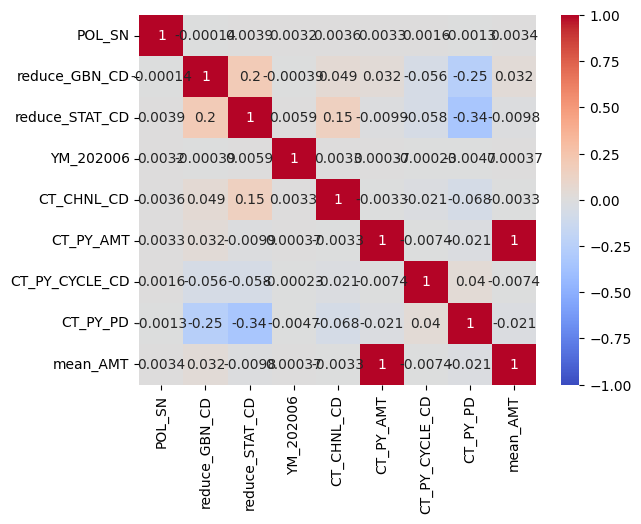

In [41]:
sns.heatmap(cont_pre6.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

In [42]:
display(cont_pre6.info())
display(cont_pre6.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 225642 entries, 280514 to 29415
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   POL_SN          225642 non-null  int64  
 1   reduce_GBN_CD   225642 non-null  int64  
 2   reduce_STAT_CD  225642 non-null  int64  
 3   YM_202006       225642 non-null  int64  
 4   CT_CHNL_CD      225642 non-null  int64  
 5   CT_PY_AMT       225642 non-null  int64  
 6   CT_PY_CYCLE_CD  225642 non-null  int64  
 7   CT_PY_PD        225642 non-null  int64  
 8   mean_AMT        225642 non-null  float64
dtypes: float64(1), int64(8)
memory usage: 17.2 MB


None

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT
count,2.256420e+05,225642.000000,225642.000000,225642.000000,225642.000000,2.256420e+05,225642.000000,225642.000000,2.256420e+05
mean,4.998216e+06,3.836857,1.793611,0.999858,7.687988,1.697522e+02,1.963065,15.820636,1.693809e+02
std,2.890178e+06,2.099662,0.974769,0.011908,21.053396,3.634121e+03,1.951120,14.634455,3.634205e+03
min,8.000000e+00,1.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,0.000000,1.000000e+00
25%,2.485840e+06,2.000000,1.000000,1.000000,1.000000,2.600000e+01,2.000000,7.000000,2.600000e+01
50%,5.002518e+06,3.000000,2.000000,1.000000,3.000000,5.100000e+01,2.000000,15.000000,5.100000e+01
75%,7.504042e+06,5.000000,2.000000,1.000000,5.000000,1.100000e+02,2.000000,20.000000,1.100000e+02
max,9.997407e+06,9.000000,4.000000,1.000000,99.000000,1.200000e+06,99.000000,99.000000,1.200000e+06


In [43]:
#납입주기 년인 금액-> 월 금액으로 맞춰주기
def get_cycle(df):
    df.loc[df['CT_PY_CYCLE_CD'] == 3, 'month_AMT'] = df.loc[df['CT_PY_CYCLE_CD'] == 3, 'mean_AMT'] / 12
    df.loc[df['CT_PY_CYCLE_CD'] != 3, 'month_AMT'] = df.loc[df['CT_PY_CYCLE_CD'] != 3, 'mean_AMT']
    return df

cont_month = get_cycle(cont_pre6)

In [44]:
#평균 납입금액 z-score/
cont_month['z_score'] = ss.zscore(cont_month['mean_AMT'])
cont_month['m_z_score'] = ss.zscore(cont_month['month_AMT'])
cont_month

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,month_AMT,z_score,m_z_score
280514,37,6,4,1,1,3,1,0,3.0,3.000000,-0.045782,-0.044223
219525,43,1,2,1,4,5000,1,0,5000.0,5000.000000,1.329212,1.337227
188875,66,3,2,1,4,98,3,1,98.0,8.166667,-0.019641,-0.042795
271367,87,7,1,1,1,1300,2,2,1300.0,1300.000000,0.311106,0.314340
274194,111,1,1,1,3,60,2,25,60.0,60.000000,-0.030098,-0.028465
...,...,...,...,...,...,...,...,...,...,...,...,...
12522,9997065,1,1,1,1,190,2,20,190.0,190.000000,0.005674,0.007474
90295,9997240,6,4,1,3,24,1,0,24.0,24.000000,-0.040004,-0.038418
140100,9997268,2,1,1,1,31,2,20,65.0,65.000000,-0.028722,-0.027083
44366,9997320,4,2,1,1,81,2,30,81.0,81.000000,-0.024319,-0.022660


### BOX-plot part

In [45]:
cont_month['reduce_GBN_CD'] = cont_month['reduce_GBN_CD'].astype(str)
cont_month.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225642 entries, 280514 to 29415
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   POL_SN          225642 non-null  int64  
 1   reduce_GBN_CD   225642 non-null  object 
 2   reduce_STAT_CD  225642 non-null  int64  
 3   YM_202006       225642 non-null  int64  
 4   CT_CHNL_CD      225642 non-null  int64  
 5   CT_PY_AMT       225642 non-null  int64  
 6   CT_PY_CYCLE_CD  225642 non-null  int64  
 7   CT_PY_PD        225642 non-null  int64  
 8   mean_AMT        225642 non-null  float64
 9   month_AMT       225642 non-null  float64
 10  z_score         225642 non-null  float64
 11  m_z_score       225642 non-null  float64
dtypes: float64(4), int64(7), object(1)
memory usage: 22.4+ MB


<Axes: xlabel='reduce_GBN_CD', ylabel='mean_AMT'>

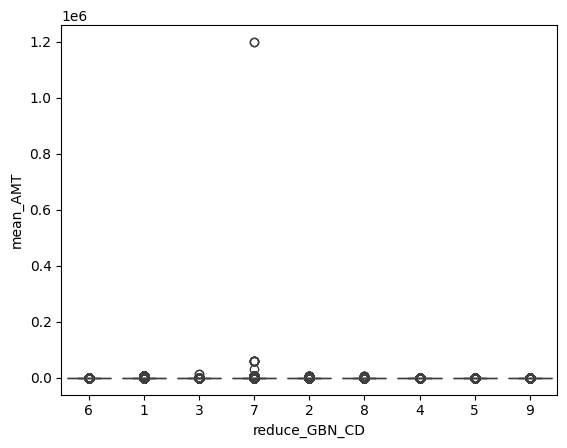

In [46]:
sns.boxplot(x = 'reduce_GBN_CD', y = "mean_AMT", data =cont_month)

❗**- 1억2천 제외하고 box-plot 그림**:

In [47]:
cont_pre7 = cont_month.drop(cont_month[cont_month['mean_AMT'] ==1200000].index,axis=0)
cont_pre7

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,month_AMT,z_score,m_z_score
280514,37,6,4,1,1,3,1,0,3.0,3.000000,-0.045782,-0.044223
219525,43,1,2,1,4,5000,1,0,5000.0,5000.000000,1.329212,1.337227
188875,66,3,2,1,4,98,3,1,98.0,8.166667,-0.019641,-0.042795
271367,87,7,1,1,1,1300,2,2,1300.0,1300.000000,0.311106,0.314340
274194,111,1,1,1,3,60,2,25,60.0,60.000000,-0.030098,-0.028465
...,...,...,...,...,...,...,...,...,...,...,...,...
12522,9997065,1,1,1,1,190,2,20,190.0,190.000000,0.005674,0.007474
90295,9997240,6,4,1,3,24,1,0,24.0,24.000000,-0.040004,-0.038418
140100,9997268,2,1,1,1,31,2,20,65.0,65.000000,-0.028722,-0.027083
44366,9997320,4,2,1,1,81,2,30,81.0,81.000000,-0.024319,-0.022660


<Axes: xlabel='reduce_GBN_CD', ylabel='mean_AMT'>

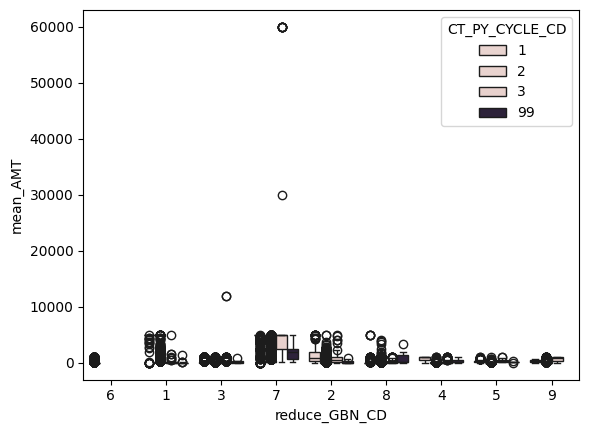

In [48]:
display(sns.boxplot(x = 'reduce_GBN_CD', y = "mean_AMT", hue = 'CT_PY_CYCLE_CD',  data = cont_pre7))

<Axes: xlabel='reduce_GBN_CD', ylabel='month_AMT'>

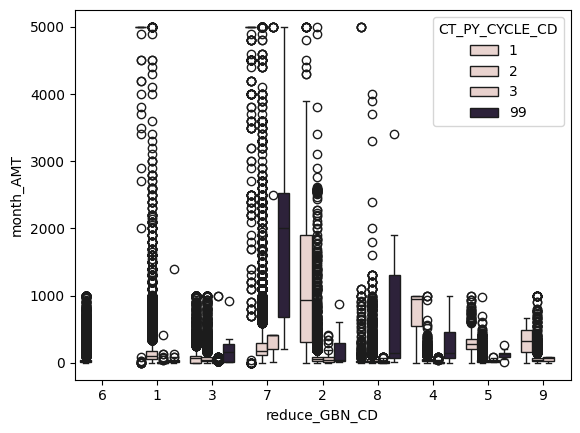

In [49]:
#월별 금액 환산 후 box plot
display(sns.boxplot(x = 'reduce_GBN_CD', y = "month_AMT", hue = 'CT_PY_CYCLE_CD',  data = cont_pre7))

<Axes: xlabel='reduce_GBN_CD', ylabel='mean_AMT'>

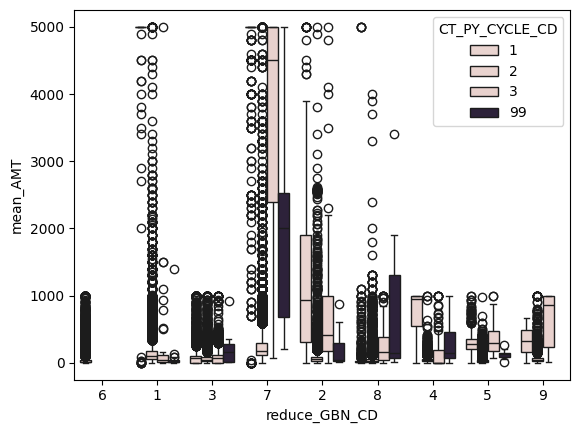

In [52]:
cont_AMT_6000_under = cont_pre6[cont_pre6['mean_AMT']<6000]
sns.boxplot(data = cont_AMT_6000_under, x = 'reduce_GBN_CD', y = "mean_AMT", hue = 'CT_PY_CYCLE_CD')

In [54]:
#z-score별 이상치
display(cont_month.loc[(cont_month['z_score'].abs()>3)])
display(cont_month.loc[(cont_month['m_z_score'].abs()>3)])

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,month_AMT,z_score,m_z_score
286886,7674,7,2,1,4,60000,3,2,60000.0,5.000000e+03,16.463228,1.337227
186051,1311568,3,1,1,4,12000,3,2,12000.0,1.000000e+03,3.255360,0.231403
129338,1521730,3,1,1,4,12000,3,3,12000.0,1.000000e+03,3.255360,0.231403
169958,2323093,7,1,1,4,60000,3,2,60000.0,5.000000e+03,16.463228,1.337227
216650,6883574,7,1,1,4,60000,3,2,60000.0,5.000000e+03,16.463228,1.337227
126544,7453475,7,1,1,1,1200000,1,0,1200000.0,1.200000e+06,330.150106,331.701978
235866,9375379,7,2,1,4,60000,3,2,60000.0,5.000000e+03,16.463228,1.337227
253116,9575679,7,1,1,4,1200000,1,0,1200000.0,1.200000e+06,330.150106,331.701978
282484,9589980,7,1,1,4,60000,3,2,60000.0,5.000000e+03,16.463228,1.337227
122777,4837144,7,4,1,4,60000,3,2,60000.0,5.000000e+03,16.463228,1.337227


,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,month_AMT,z_score,m_z_score
126544,7453475,7,1,1,1,1200000,1,0,1200000.0,1200000.0,330.150106,331.701978
253116,9575679,7,1,1,4,1200000,1,0,1200000.0,1200000.0,330.150106,331.701978


-  납입보험료 이modf상치 판단
- 보종 코드별로 봤을 때, 평균적으로 얼마정도에 금액이 형성이 되고, 갑자기 어느 구간에서 이상치가 확 늘어나는지 등에 대한 EDA 필요

## 보험 종류별로 dataframe쪼개서 보험료 분포확인할 예정


In [55]:
cont_month

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,month_AMT,z_score,m_z_score
280514,37,6,4,1,1,3,1,0,3.0,3.000000,-0.045782,-0.044223
219525,43,1,2,1,4,5000,1,0,5000.0,5000.000000,1.329212,1.337227
188875,66,3,2,1,4,98,3,1,98.0,8.166667,-0.019641,-0.042795
271367,87,7,1,1,1,1300,2,2,1300.0,1300.000000,0.311106,0.314340
274194,111,1,1,1,3,60,2,25,60.0,60.000000,-0.030098,-0.028465
...,...,...,...,...,...,...,...,...,...,...,...,...
12522,9997065,1,1,1,1,190,2,20,190.0,190.000000,0.005674,0.007474
90295,9997240,6,4,1,3,24,1,0,24.0,24.000000,-0.040004,-0.038418
140100,9997268,2,1,1,1,31,2,20,65.0,65.000000,-0.028722,-0.027083
44366,9997320,4,2,1,1,81,2,30,81.0,81.000000,-0.024319,-0.022660


In [56]:
cont_month['reduce_GBN_CD'].unique()

array(['6', '1', '3', '7', '2', '8', '4', '5', '9'], dtype=object)

In [57]:
GBN_1=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='1']
GBN_2=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='2']
GBN_3=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='3']
GBN_4=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='4']
GBN_5=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='5']
GBN_6=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='6']
GBN_7=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='7']
GBN_8=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='8']
GBN_9=cont_pre6.loc[cont_pre6['reduce_GBN_CD']=='9']

Text(0.5, 1.0, '화재')

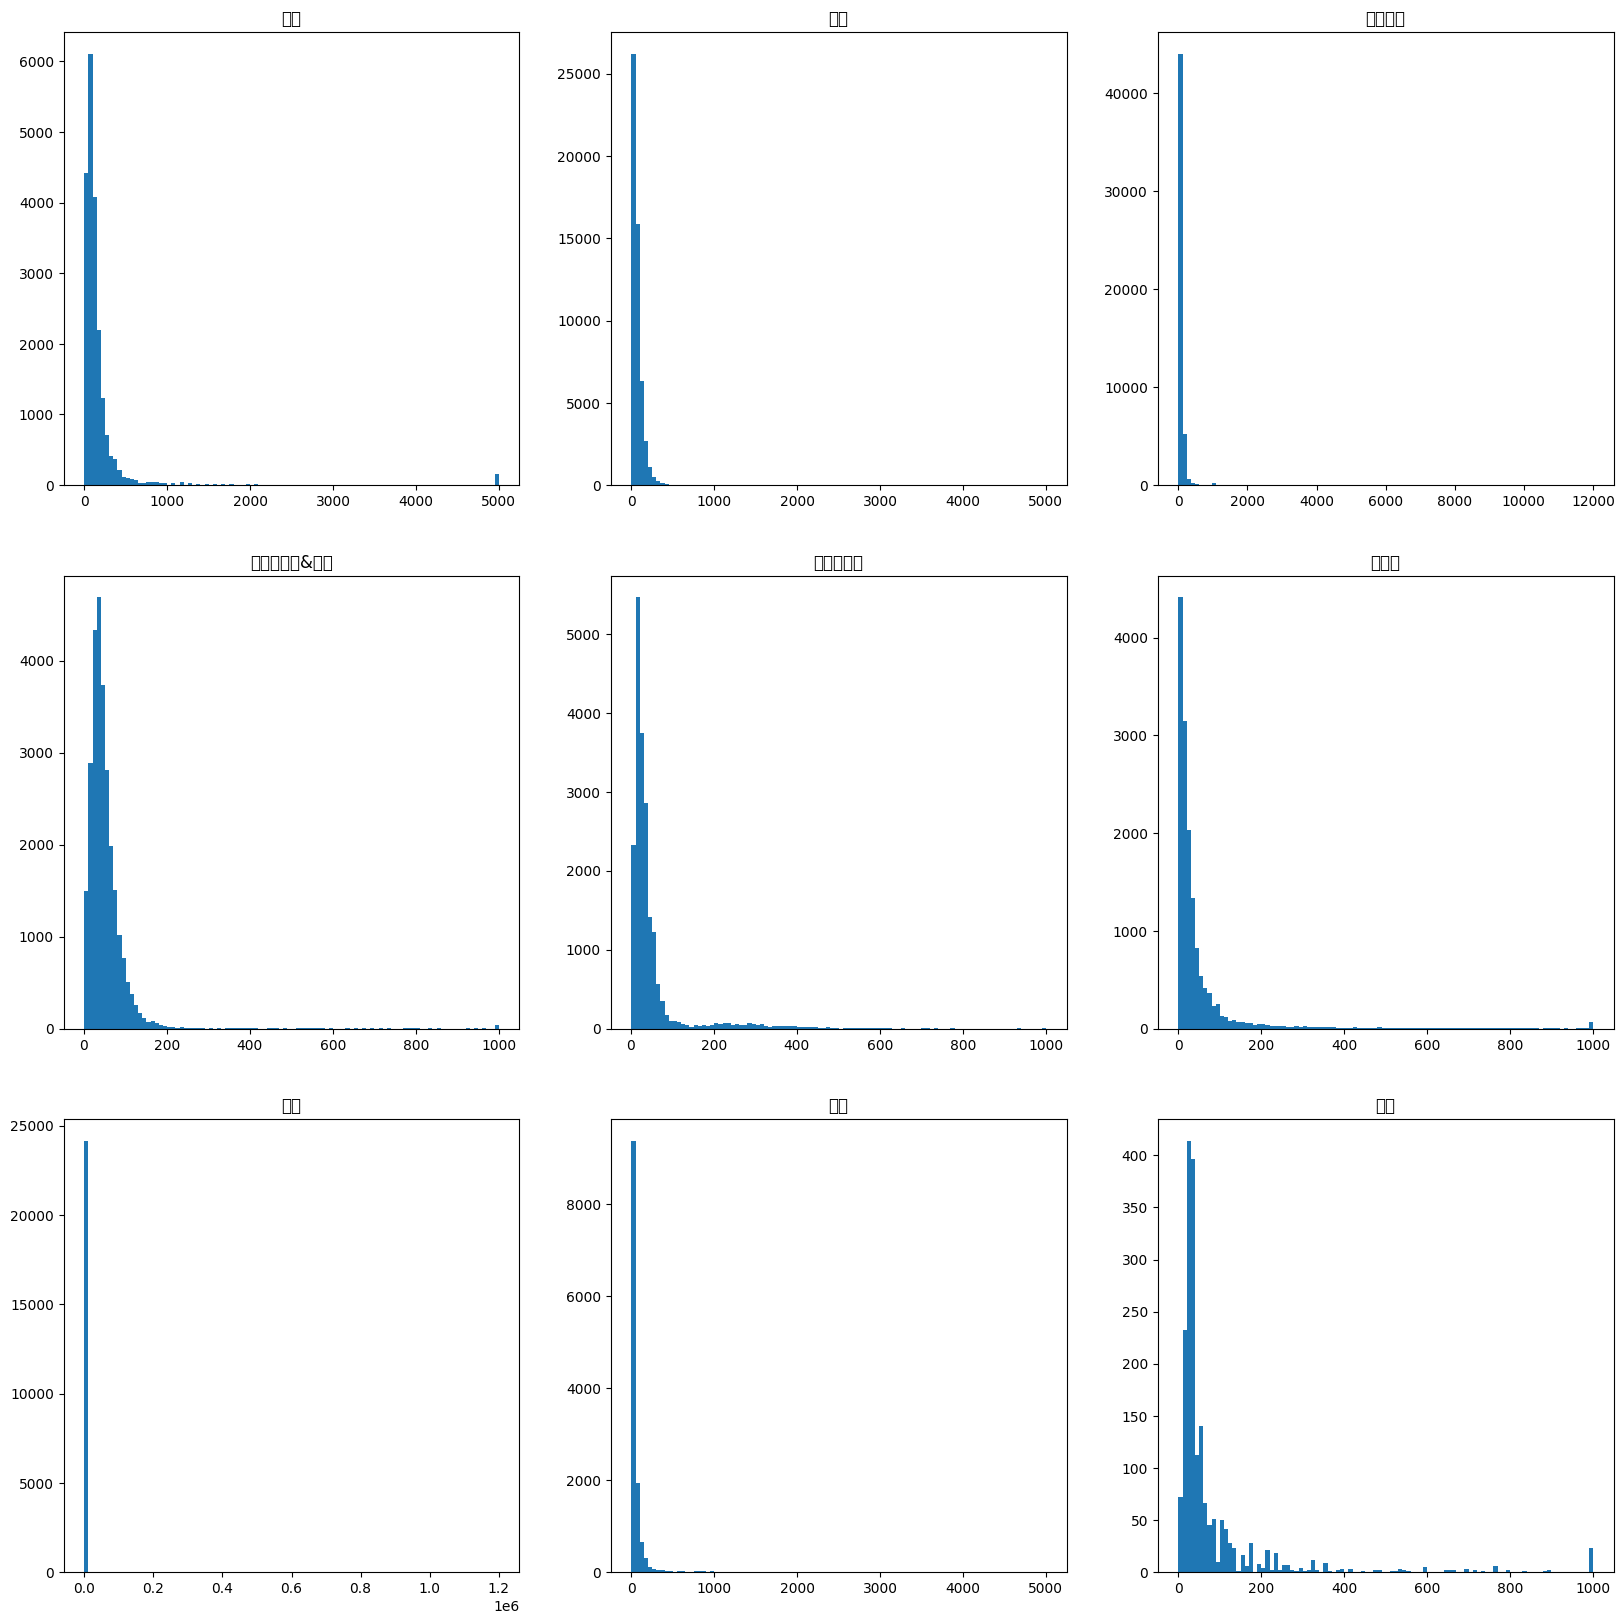

In [58]:
fig, axs = plt.subplots(3, 3, figsize=(20, 20))

# 첫 번째 그래프
axs[0, 0].hist(GBN_1['mean_AMT'], bins= 100)
axs[0, 0].set_title('사망')

axs[0, 1].hist(GBN_2['mean_AMT'], bins= 100)
axs[0, 1].set_title('질병')

axs[0, 2].hist(GBN_3['mean_AMT'], bins= 100)
axs[0, 2].set_title('상해보험')

axs[1, 0].hist(GBN_4['mean_AMT'], bins= 100)
axs[1, 0].set_title('어린이보험&실비')

axs[1, 1].hist(GBN_5['mean_AMT'], bins= 100)
axs[1, 1].set_title('운전자보험')

axs[1, 2].hist(GBN_6['mean_AMT'], bins= 100)
axs[1, 2].set_title('여행자')

axs[2, 0].hist(GBN_7['mean_AMT'], bins= 100)
axs[2, 0].set_title('연금')

axs[2, 1].hist(GBN_8['mean_AMT'], bins= 100)
axs[2, 1].set_title('기타')

axs[2, 2].hist(GBN_9['mean_AMT'], bins= 100)
axs[2, 2].set_title('화재')



금액대 형성  
0~1백 :4,5, 6,9(어린이&실비,운전자, 여행자 , 화재)  
0~5백 : 1,2,8(사망, 질병, 기타)  
0~ 1천 2백 : 3(상해보험)  
0~1억2천 : 연금


In [59]:
GBN_7['mean_AMT'].value_counts()

mean_AMT
5000.000000    2581
120.000000     1489
110.000000     1299
240.000000     1147
90.000000      1073
               ... 
182.000000        1
172.000000        1
313.333333        1
105.500000        1
60.750000         1
Name: count, Length: 391, dtype: int64

<Axes: xlabel='mean_AMT', ylabel='Count'>

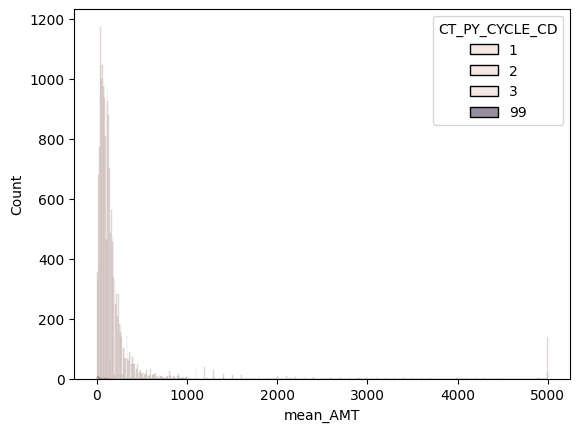

In [60]:
sns.histplot(data=GBN_1, x="mean_AMT", hue='CT_PY_CYCLE_CD')

In [61]:
cont_fi =cont_month.loc[(cont_month['m_z_score'].abs()<3)]
cont_fi

,POL_SN,reduce_GBN_CD,reduce_STAT_CD,YM_202006,CT_CHNL_CD,CT_PY_AMT,CT_PY_CYCLE_CD,CT_PY_PD,mean_AMT,month_AMT,z_score,m_z_score
280514,37,6,4,1,1,3,1,0,3.0,3.000000,-0.045782,-0.044223
219525,43,1,2,1,4,5000,1,0,5000.0,5000.000000,1.329212,1.337227
188875,66,3,2,1,4,98,3,1,98.0,8.166667,-0.019641,-0.042795
271367,87,7,1,1,1,1300,2,2,1300.0,1300.000000,0.311106,0.314340
274194,111,1,1,1,3,60,2,25,60.0,60.000000,-0.030098,-0.028465
...,...,...,...,...,...,...,...,...,...,...,...,...
12522,9997065,1,1,1,1,190,2,20,190.0,190.000000,0.005674,0.007474
90295,9997240,6,4,1,3,24,1,0,24.0,24.000000,-0.040004,-0.038418
140100,9997268,2,1,1,1,31,2,20,65.0,65.000000,-0.028722,-0.027083
44366,9997320,4,2,1,1,81,2,30,81.0,81.000000,-0.024319,-0.022660


# 최종 데이터 프레임
- cont_fi
- mgg_pre3

In [62]:
cont_fi.to_csv('cont_fi.csv', index=False)
mgg_pre3.to_csv('mgg_fi.csv', index=False)